## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.7]
redice_lr_patient = [2, 8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

W0110 18:14:27.144463 4831362496 deprecation_wrapper.py:119] From /Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.2224 - accuracy: 0.2716 - val_loss: 2.1375 - val_accuracy: 0.1930
Epoch 2/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.7468 - accuracy: 0.3937 - val_loss: 1.9594 - val_accuracy: 0.3084
Epoch 3/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6211 - accuracy: 0.4336 - val_loss: 1.8181 - val_accuracy: 0.3787
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5507 - accuracy: 0.4552 - val_loss: 1.7065 - val_accuracy: 0.4108
Epoch 5/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4956 - accuracy: 0.4747 - val_loss: 1.6333 - val_accuracy: 0.4352
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4526 - accuracy: 0.4904 - val_loss: 1.5828 - val_accuracy: 0.4423
Epoch 7/25
50000/50000 [==============================] - 2s 49us/st

Epoch 21/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1003 - accuracy: 0.6216 - val_loss: 1.4569 - val_accuracy: 0.4900
Epoch 22/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.0827 - accuracy: 0.6274 - val_loss: 1.4531 - val_accuracy: 0.4905
Epoch 23/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.0638 - accuracy: 0.6360 - val_loss: 1.4517 - val_accuracy: 0.4949
Epoch 24/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.0490 - accuracy: 0.6406 - val_loss: 1.4602 - val_accuracy: 0.4909
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.0321 - accuracy: 0.6477 - val_loss: 1.4700 - val_accuracy: 0.4865
Numbers of exp: 2, reduce_factor: 0.70, reduce_patient: 2
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)            

Epoch 5/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.6298 - accuracy: 0.4307 - val_loss: 1.7252 - val_accuracy: 0.4001
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5853 - accuracy: 0.4470 - val_loss: 1.6813 - val_accuracy: 0.4045
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5488 - accuracy: 0.4590 - val_loss: 1.6353 - val_accuracy: 0.4192
Epoch 8/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5165 - accuracy: 0.4698 - val_loss: 1.6205 - val_accuracy: 0.4233
Epoch 9/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.4895 - accuracy: 0.4808 - val_loss: 1.5922 - val_accuracy: 0.4322
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4642 - accuracy: 0.4882 - val_loss: 1.5758 - val_accuracy: 0.4417
Epoch 11/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4420 - accuracy: 0.4967 - val_loss:

50000/50000 [==============================] - 3s 55us/step - loss: 0.7754 - accuracy: 0.7449 - val_loss: 1.3132 - val_accuracy: 0.5512
Epoch 23/25
50000/50000 [==============================] - 2s 50us/step - loss: 0.7746 - accuracy: 0.7460 - val_loss: 1.3135 - val_accuracy: 0.5509

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
Epoch 24/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.7753 - accuracy: 0.7440 - val_loss: 1.3137 - val_accuracy: 0.5505
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.7747 - accuracy: 0.7458 - val_loss: 1.3139 - val_accuracy: 0.5507

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 8
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)         

50000/50000 [==============================] - 3s 54us/step - loss: 3.1343 - accuracy: 0.0978 - val_loss: 2.5540 - val_accuracy: 0.1046
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.1345 - accuracy: 0.0976 - val_loss: 2.6311 - val_accuracy: 0.1038

Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.680203555933019e-10.
Epoch 6/25
50000/50000 [==============================] - 3s 57us/step - loss: 3.1353 - accuracy: 0.0978 - val_loss: 2.7086 - val_accuracy: 0.1044
Epoch 7/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.1340 - accuracy: 0.0981 - val_loss: 2.7849 - val_accuracy: 0.1029

Epoch 00007: ReduceLROnPlateau reducing learning rate to 6.076142644584337e-10.
Epoch 8/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.1353 - accuracy: 0.0974 - val_loss: 2.8569 - val_accuracy: 0.1020
Epoch 9/25
50000/50000 [==============================] - 3s 57us/step - loss: 3.1342 - accuracy: 0.0976 - val_los

50000/50000 [==============================] - 2s 48us/step - loss: 3.0707 - accuracy: 0.1055 - val_loss: 3.0259 - val_accuracy: 0.1036

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.2014520281433682e-11.
Epoch 18/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.0702 - accuracy: 0.1058 - val_loss: 3.0315 - val_accuracy: 0.1039
Epoch 19/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.0715 - accuracy: 0.1060 - val_loss: 3.0350 - val_accuracy: 0.1040
Epoch 20/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.0713 - accuracy: 0.1054 - val_loss: 3.0371 - val_accuracy: 0.1040
Epoch 21/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.0697 - accuracy: 0.1047 - val_loss: 3.0383 - val_accuracy: 0.1037
Epoch 22/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.0716 - accuracy: 0.1062 - val_loss: 3.0393 - val_accuracy: 0.1036
Epoch 23/25
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0608 - accuracy: 0.0922 - val_loss: 2.3566 - val_accuracy: 0.0934
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.0365 - accuracy: 0.0943 - val_loss: 2.3985 - val_accuracy: 0.0842
Epoch 3/25
50000/50000 [==============================] - 2s 47us/step - loss: 3.0133 - accuracy: 0.0967 - val_loss: 2.4591 - val_accuracy: 0.0848
Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.9889 - accuracy: 0.0981 - val_loss: 2.5135 - val_accuracy: 0.0888
Epoch 5/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.9665 - accuracy: 0.1009 - val_loss: 2.5560 - val_accuracy: 0.0930
Epoch 6/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.9450 - accuracy: 0.1034 - val_loss: 2.5901 - val_accuracy: 0.0991
Epoch 7/25
50000/50000 [==============================] - 2s 47us/st


Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.86293938450899e-10.
Epoch 16/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.9478 - accuracy: 0.1278 - val_loss: 2.9230 - val_accuracy: 0.1309
Epoch 17/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.9490 - accuracy: 0.1277 - val_loss: 2.9295 - val_accuracy: 0.1313

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.404057646871905e-10.
Epoch 18/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.9478 - accuracy: 0.1269 - val_loss: 2.9338 - val_accuracy: 0.1306
Epoch 19/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.9498 - accuracy: 0.1277 - val_loss: 2.9363 - val_accuracy: 0.1299

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.382840313952528e-10.
Epoch 20/25
50000/50000 [==============================] - 2s 47us/step - loss: 2.9484 - accuracy: 0.1265 - val_loss: 2.9379 - val_accuracy: 0.1300
Epoch 21/25
50000/

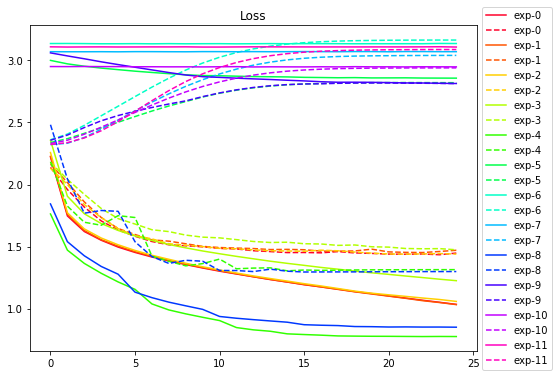

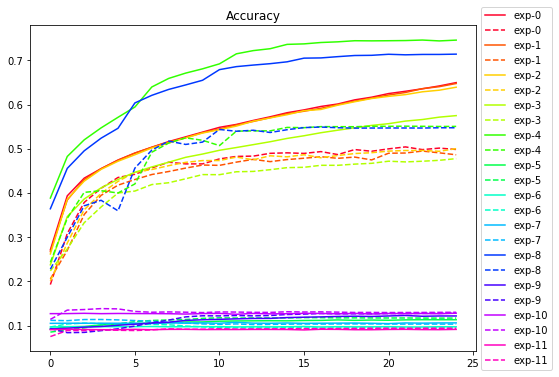

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()